In [1]:
import numpy as np
import seaborn as sns
from stochastic_processes import StochasticProcess, StochasticIntegration, SdeSolver, Functionmaker

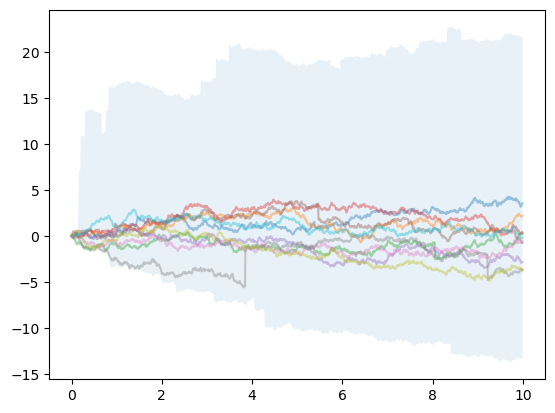

In [3]:
process = StochasticProcess(time=10, timestep=0.01, number=100, poisson_rate=10, shape=1, scale=1)
t, Xt = process.levyprocess()
process.plot_solution(t, Xt, with_mean=False, with_var=False, num_max=10)

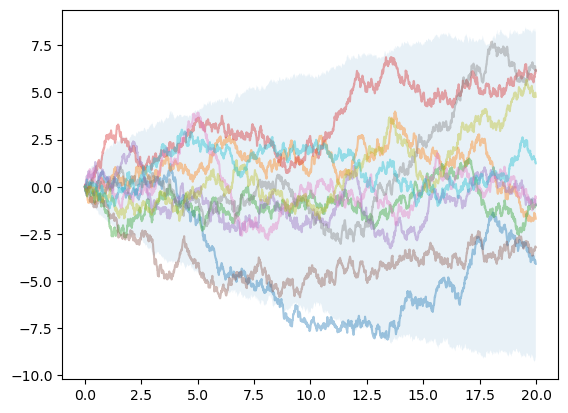

In [10]:
process = StochasticProcess(time=20, timestep=0.01, number=500, poisson_rate=6, shape=1, scale=1)
t, Xt = process.brownianmotion()
process.plot_solution(t, Xt, num_max=10)    

In [12]:
# from stochastic_processes import StochasticProcess
process = StochasticProcess(time=10, timestep=0.0001, number=250, poisson_rate=6, shape=1, scale=1)
t, Xt = process.brownianmotion()

mean_stop, var_stop = process.stoppingstatistics(Xt, t, tau=1) # Mean is about half. Should be 1.
print(mean_stop, var_stop)

0.9710352 0.5695708877209601


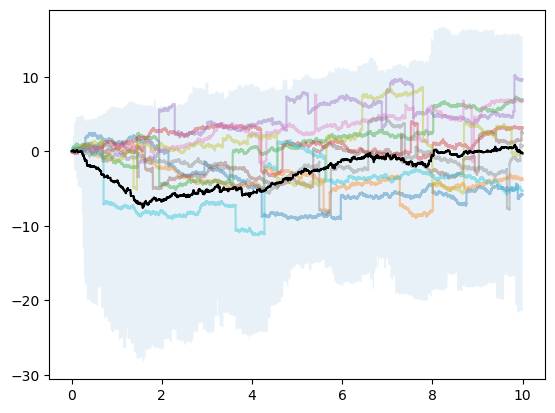

(0.595605, 0.311368401275)

In [17]:
# from stochastic_processes import StochasticProcess
process = StochasticProcess(time=10, timestep=0.0001, number=100, poisson_rate=1, shape=1, scale=1)
t, Xt = process.levyprocess()

process.plot_solution(t, Xt, with_mean=True, num_max=10)
process.stoppingstatistics(Xt, t, tau=1)

c:\Users\gouwenss\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

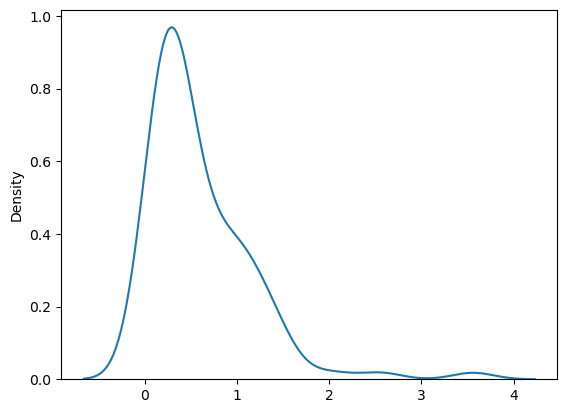

In [18]:
stopping_indices = process.findstoppingindices(Xt, tau=1)
stopping_times = t[stopping_indices]

sns.kdeplot(stopping_times)

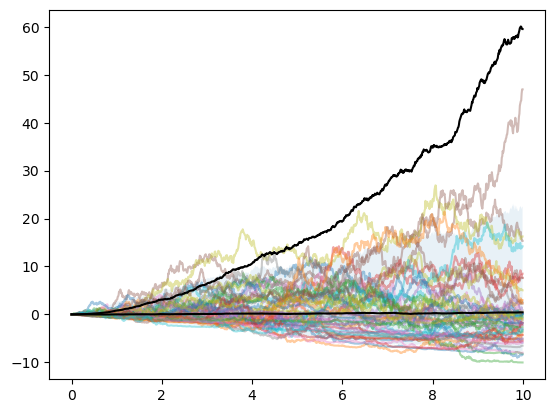

In [4]:
f_function = lambda t, x: np.sin(t) + x

integrate = StochasticIntegration(time=10, timestep=0.01, number=1000, shape=1, scale=0.1, integrator="brownianmotion")
t, Xt = integrate.stochastic_integral(fun=integrate.f_func)
integrate.plot_solution(t, Xt, num_max=50, with_mean=True, with_var=True)

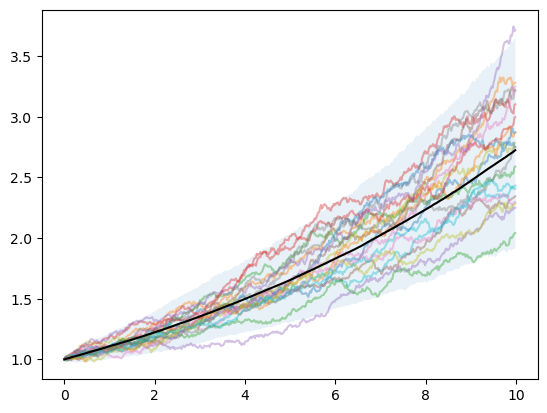

0.3167953693602123 0.09829280438032044


In [20]:
sdesolve = SdeSolver(time=10, timestep=0.02, number=1000, poisson_rate=10, shape=.2, scale=2, integrator="brownianmotion")

t, Xt = sdesolve.solve_sde(f_func=sdesolve.f_blackscholes, g_func=sdesolve.g_blackscholes, value_init=1)
sdesolve.plot_solution(t, Xt, with_mean=True, with_var=False)

returns = sdesolve.european_option(t, Xt, call_time=9, strike_price=2.2)

print(np.mean(returns), np.var(returns))

In [19]:
# Do thest this. add a function f and g such that the parameters give prettier results.
sdesolve = SdeSolver(time=10, timestep=0.02, number=2500, poisson_rate=4, shape=1, scale=1, integrator="brownianmotion")
t, Xt = sdesolve.solve_sde(value_init=1)

sdesolve.plot_solution(t, Xt, with_mean=True, with_var=False)

TypeError: SdeSolver.solve_sde() missing 2 required positional arguments: 'f_func' and 'g_func'

In [49]:
alpha = 1.1
beta = 0.7
delta = 1
gamma = 0.5
sigma1 = 0.01
sigma2 = 0.01

f_funs = Functionmaker().generate_linears(part_x=[alpha, 0],  part_y=[0, -gamma], part_x_y=[-beta, delta])
g_funs = Functionmaker().generate_linears(part_x=[sigma1, 0], part_y=[0, sigma2])

In the next, we create use Functionmaker to generate the function used in the Lotka Volterra SDE. Note that in normal literature, this is a normal system of differential equations, but a small adjustment turns it into a system of stochastic differential equations. The original is given by:

$$\frac{dx}{dt}=\alpha x(t)- \beta x(t)y(t)$$
$$\frac{dx}{dt}=\delta x(t)y(t)- \gamma y(t)$$

Rewrite into differential form, and add noise that is proportional to the population size yields

$$dX_t = (\alpha X_t - \beta X_tY_t)dt + \sigma_1X_tdB_t$$
$$dY_t = (\delta X_tY_t - \gamma Y_t)dt + \sigma_2Y_tdB_t$$

If $y(t)$ is constant in the upper line, it closely resembles the Black-Scholes equation, but more in an ecological context. In our simulation we choose the values:


$\alpha=X, \beta=X, \delta=X, \gamma=X$

The Funtionmaker.generate_linears method makes a list of functions of the type 
$$f(t, x) = c_0 + c_1t + c_3x + c_4y + c_5xy.$$
This relates to SDE's as they are written in the general form
$$dX_t = f(t, X_t)dt + g(t, X_t)dB_t$$

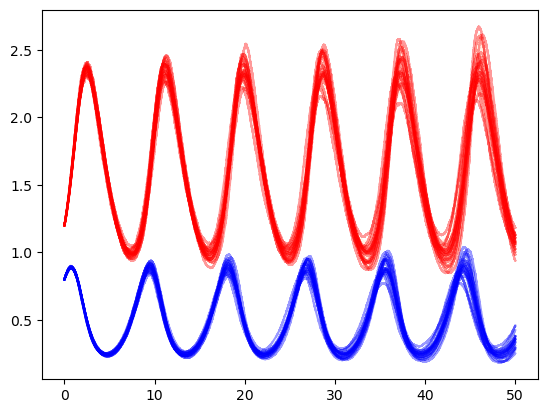

In [51]:
sdesolve = SdeSolver(time=50, timestep=0.0001, number=25, poisson_rate=4, shape=1, scale=1, integrator="brownianmotion")

t, Mt = sdesolve.integrator()
_, M2t = sdesolve.integrator()

dMt = np.hstack((np.diff(Mt), np.zeros((Mt.shape[0], 1)))) 
dM2t = np.hstack((np.diff(Mt), np.zeros((Mt.shape[0], 1)))) 

Xt = np.full_like(Mt, fill_value=.8) 
Yt = np.full_like(Mt, fill_value=1.2) 

for i in range(1, Mt.shape[1]):
    Xt[:,i] = Xt[:,i-1] + f_funs[0](t[t_], Xt[:,i-1], Yt[:,i-1])*sdesolve.timestep + g_funs[0](t[i-1], Xt[:,i-1], Yt[:,i-1])*dMt[:,i]
    Yt[:,i] = Yt[:,i-1] + f_funs[1](t[t_], Xt[:,i-1], Yt[:,i-1])*sdesolve.timestep + g_funs[1](t[i-1], Xt[:,i-1], Yt[:,i-1])*dM2t[:,i]

sdesolve.plot_solution(t, Xt, color="blue", show=False)
sdesolve.plot_solution(t, Yt, color="red")


Similarly to the Lotka-Volterra model we can solve the Heston equation. This equation is given by

$$dSt=\mu S_tdt+\sqrt v_tS_tdW_t^{(1)}$$
$$dvt=\kappa(\theta-v_t)dt+\sigma \sqrt v_tdW_t^{(2)}$$

In [6]:
f1_Heston = lambda t, x, y: 0.2*x
f2_Heston = lambda t, x, y: np.sqrt(y)*x
g1_Heston = lambda t, x, y: 0.1*(0.7-y)
g2_Heston = lambda t, x, y: 0.01*np.sqrt(y)

f_heston = [f1_Heston, f2_Heston]
g_heston = [g1_Heston, g2_Heston]

Having the functions defined, we can simulate. However, realistic values are not yet chosen.

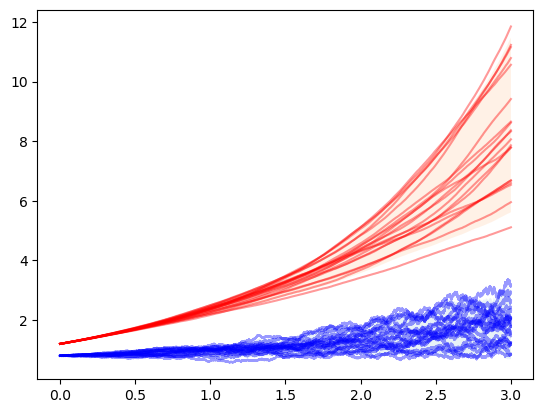

In [12]:
sdesolve = SdeSolver(time=3, timestep=0.0001, number=25, poisson_rate=4, shape=1, scale=1, integrator="brownianmotion")

t, Wt1 = sdesolve.integrator()
_, Wt2 = sdesolve.integrator()

dWt1 = np.hstack((np.diff(Wt1), np.zeros((Wt1.shape[0], 1)))) 
dWt2 = np.hstack((np.diff(Wt2), np.zeros((Wt1.shape[0], 1)))) 

Xt = np.full_like(Wt1, fill_value=.8) 
Yt = np.full_like(Wt1, fill_value=1.2) 

for i in range(1, Wt1.shape[1]):
    Xt[:,i] = Xt[:,i-1] + f_heston[0](t[i-1], Xt[:,i-1], Yt[:,i-1])*sdesolve.timestep + g_heston[0](t[i-1], Xt[:,i-1], Yt[:,i-1])*dWt1[:,i]
    Yt[:,i] = Yt[:,i-1] + f_heston[1](t[i-1], Xt[:,i-1], Yt[:,i-1])*sdesolve.timestep + g_heston[1](t[i-1], Xt[:,i-1], Yt[:,i-1])*dWt2[:,i]

sdesolve.plot_solution(t, Xt, color="blue", show=False)
sdesolve.plot_solution(t, Yt, color="red")


It may be interesting to generalise the system approach such that any number of equations can be solved. This is not of interest at this point, so we stick with the above.